In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import dataloader, Dataset
from model_and_dataset import time_data, TS_LSTM
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import csv

In [2]:
class arguments():
    def __init__(self):
        """
        Hyperparams for the models
        """
        # input_dim: the # of LSTMnodes, also the time series window
        self.input_dim = 12
        # the hidden_dim of the model
        self.hidden_dim= 18

        self.learning_rate = 5e-5
        
        self.training_iter = 500
args = arguments()

In [3]:
def get_XY(raw_data, window):
    """
    Get the time series data from the pd.Series
    """
    X_data, y_data = [],[]
    for i in range(len(raw_data)-window-1):
        X_data.append(raw_data[i:i+window])
        y_data.append(raw_data[i+window])
    return np.array(X_data), np.array(y_data)

In [4]:
def get_dataset(csvFile, window ,boro = "Manhattan"):
    """Get the dataset(in type of np.array)
    Params:
        csvFile: data source 
        window: time series window
        boro: the chosen boro that would be built model on
    Outputs:
        X_train,y_train,X_test,y_test: train/test set
        max_x/min_x: the max/min before the scaler(used to retore data to original scale) 
    """
    
    tonnage = pd.read_csv("DSNY_Monthly_Tonnage_Data.csv")
    Man = tonnage.loc[tonnage["BOROUGH"] == boro,["MONTH","REFUSETONSCOLLECTED"]].groupby(by="MONTH").sum()
    Man = Man.loc[(Man.index >="2010 / 01"),:]
    Man["scaled"] = (Man["REFUSETONSCOLLECTED"] - min(Man["REFUSETONSCOLLECTED"])) / (max(Man["REFUSETONSCOLLECTED"]) - min(Man["REFUSETONSCOLLECTED"]))
    X, y = get_XY(Man["scaled"], window)
    X_train, y_train = X[:int(len(X)*0.7)], y[:int(len(X)*0.7)]
    X_test, y_test   = X[int(len(X)*0.7):], y[int(len(X)*0.7):]
    return (X_train,y_train,X_test,y_test,max(Man["REFUSETONSCOLLECTED"]), min(Man["REFUSETONSCOLLECTED"]) )

In [5]:
def predict_all(model,train_loader, test_loader):
    """ Use the model to predict on both training and testing set, then stack them together"""
    with torch.no_grad():
        y_preds = np.array([])
        for i,(data_batch, data_label) in enumerate(train_loader):    
            y_pred = model(data_batch.to(device)).cpu().detach().numpy()
            # print(y_pred)
            y_preds = np.append(y_preds,y_pred)

        for i,(data_batch, data_label) in enumerate(test_loader):
            y_pred = model(data_batch.to(device)).cpu().detach().numpy()
            y_preds = np.append(y_preds,y_pred)
    return y_preds

In [18]:
def training_boro_models(boro, plot = False):
    ## initializing data, X_max and X_min are used to 从scale还原data
    X_train,y_train,X_test,y_test, X_max, X_min = get_dataset("DSNY_Monthly_Tonnage_Data.csv", args.input_dim, boro)
    training_set = time_data(X_train,y_train,args.input_dim)
    testing_set  = time_data(X_test,y_test,args.input_dim)
    train_loader = dataloader.DataLoader(dataset=training_set)
    test_loader  = dataloader.DataLoader(dataset=testing_set)
    
    ## initializing models
    model = TS_LSTM(args.input_dim,args.hidden_dim)
    optimizer = nn.optimizer = torch.optim.Adam(model.parameters(),lr = args.learning_rate)
    loss_func = nn.MSELoss()
    
    # if cuda exists, use cuda, else run on cpu
    global device
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device('cpu')
    model.to(device)
    
    ## training models
    train_loss_history = []
    for i in range(args.training_iter):
        # model.train()
        for j,(data_batch, data_label) in enumerate(train_loader):
            preds = model(data_batch.to(device))
            loss = loss_func(preds, data_label.to(device))
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
        train_loss_history.append(loss.item())
        if (i % 10) == 0:
            print("Trainig epoch: {}, loss {}".format(str(i),loss))
    ## save the model
    torch.save(model, "{}_Model".format(boro))
    
    ## predict the results
    labels_pred = predict_all(model, train_loader, test_loader)
    if plot:
        refuse_real = np.append(y_train,y_test)*(X_max - X_min) + X_min
        refuse_pred = labels_pred*(X_max - X_min) + X_min
        f,ax = plt.subplots(figsize=(10,7))
        ax.set_title("{} monthly refuse tonnage ".format(boro))
        ax.plot(refuse_real,color="green",label="real")
        ax.plot(refuse_pred,color="orange",label="predicted")
        ax.legend()

    return (model, [refuse_real,refuse_pred])
    

Trainig epoch: 0, loss 0.7525100111961365
Trainig epoch: 10, loss 0.28216463327407837
Trainig epoch: 20, loss 0.0032944369595497847
Trainig epoch: 30, loss 0.0001904982782434672
Trainig epoch: 40, loss 0.00018735068442765623
Trainig epoch: 50, loss 0.0001899507624329999
Trainig epoch: 60, loss 0.0001906447287183255
Trainig epoch: 70, loss 0.00018970604287460446
Trainig epoch: 80, loss 0.0001877147296909243
Trainig epoch: 90, loss 0.000185277676791884
Trainig epoch: 100, loss 0.00018292265303898603
Trainig epoch: 110, loss 0.00018098659347742796
Trainig epoch: 120, loss 0.0001796084106899798
Trainig epoch: 130, loss 0.00017885671695694327
Trainig epoch: 140, loss 0.00017880411178339273
Trainig epoch: 150, loss 0.00017949659377336502
Trainig epoch: 160, loss 0.00018099782755598426
Trainig epoch: 170, loss 0.000183350159204565
Trainig epoch: 180, loss 0.00018658782937563956
Trainig epoch: 190, loss 0.00019072210125159472
Trainig epoch: 200, loss 0.0001957430358743295
Trainig epoch: 210, l

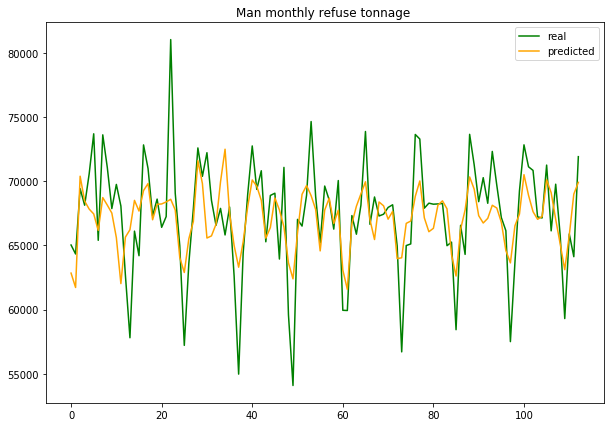

In [9]:
bk_model, results = training_boro_models("Brooklyn", plot = True)

In [15]:
import csv
with open("Bk.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["real","predicted"])
    for i in range(len(results[0])):
        writer.writerow([results[0][i],results[1][i]])

Trainig epoch: 0, loss 0.8525846600532532
Trainig epoch: 10, loss 0.24027405679225922
Trainig epoch: 20, loss 0.0076944283209741116
Trainig epoch: 30, loss 0.005089246202260256
Trainig epoch: 40, loss 0.004841296002268791
Trainig epoch: 50, loss 0.004556064493954182
Trainig epoch: 60, loss 0.004235435742884874
Trainig epoch: 70, loss 0.0038887979462742805
Trainig epoch: 80, loss 0.003523308550938964
Trainig epoch: 90, loss 0.003144964575767517
Trainig epoch: 100, loss 0.0027590368408709764
Trainig epoch: 110, loss 0.0023703468032181263
Trainig epoch: 120, loss 0.001984044210985303
Trainig epoch: 130, loss 0.0016058674082159996
Trainig epoch: 140, loss 0.0012427479960024357
Trainig epoch: 150, loss 0.0009046283666975796
Trainig epoch: 160, loss 0.0006057686405256391
Trainig epoch: 170, loss 0.000360820849891752
Trainig epoch: 180, loss 0.00017936885706149042
Trainig epoch: 190, loss 6.372018833644688e-05
Trainig epoch: 200, loss 8.626079761597794e-06
Trainig epoch: 210, loss 2.553796093

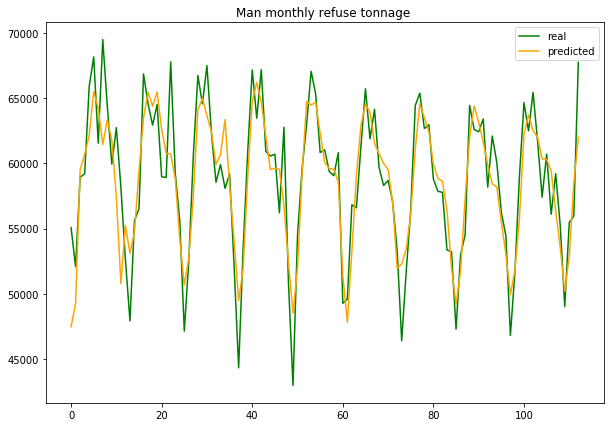

In [16]:
bk_model, results = training_boro_models("Queens", plot = True)

Trainig epoch: 0, loss 0.46623528003692627
Trainig epoch: 10, loss 0.10959312319755554
Trainig epoch: 20, loss 0.0008402249077335
Trainig epoch: 30, loss 0.0006517129368148744
Trainig epoch: 40, loss 0.0006835226668044925
Trainig epoch: 50, loss 0.0007042946526780725
Trainig epoch: 60, loss 0.0007148052682168782
Trainig epoch: 70, loss 0.0007174754282459617
Trainig epoch: 80, loss 0.0007149996818043292
Trainig epoch: 90, loss 0.0007095243781805038
Trainig epoch: 100, loss 0.0007024167571216822
Trainig epoch: 110, loss 0.0006944210035726428
Trainig epoch: 120, loss 0.0006859245477244258
Trainig epoch: 130, loss 0.0006771081243641675
Trainig epoch: 140, loss 0.0006680806400254369
Trainig epoch: 150, loss 0.0006588872638531029
Trainig epoch: 160, loss 0.0006495692068710923
Trainig epoch: 170, loss 0.0006401546415872872
Trainig epoch: 180, loss 0.0006306441500782967
Trainig epoch: 190, loss 0.0006210770225152373
Trainig epoch: 200, loss 0.0006114298012107611
Trainig epoch: 210, loss 0.0006

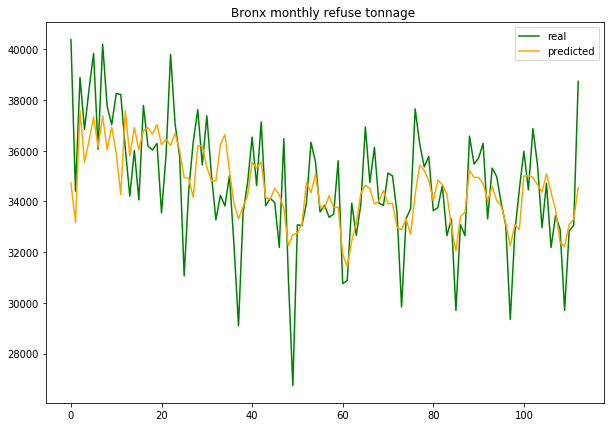

In [20]:
args.training_iter = 1200
bk_model, results = training_boro_models("Bronx", plot = True)

In [21]:
import csv
with open("Bronx.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["real","predicted"])
    for i in range(len(results[0])):
        writer.writerow([results[0][i],results[1][i]])

Trainig epoch: 0, loss 0.7325730323791504
Trainig epoch: 10, loss 0.31578925251960754
Trainig epoch: 20, loss 0.012541954405605793
Trainig epoch: 30, loss 0.0047238534316420555
Trainig epoch: 40, loss 0.004498050082474947
Trainig epoch: 50, loss 0.004325077403336763
Trainig epoch: 60, loss 0.004150264896452427
Trainig epoch: 70, loss 0.003976539243012667
Trainig epoch: 80, loss 0.003805579151958227
Trainig epoch: 90, loss 0.00363780721090734
Trainig epoch: 100, loss 0.003472967306151986
Trainig epoch: 110, loss 0.0033104605972766876
Trainig epoch: 120, loss 0.003149572294205427
Trainig epoch: 130, loss 0.002989523345604539
Trainig epoch: 140, loss 0.002829593839123845
Trainig epoch: 150, loss 0.002669199137017131
Trainig epoch: 160, loss 0.002507827477529645
Trainig epoch: 170, loss 0.0023452595341950655
Trainig epoch: 180, loss 0.002181279705837369
Trainig epoch: 190, loss 0.002015142934396863
Trainig epoch: 200, loss 0.001846764236688614
Trainig epoch: 210, loss 0.001676512067206204


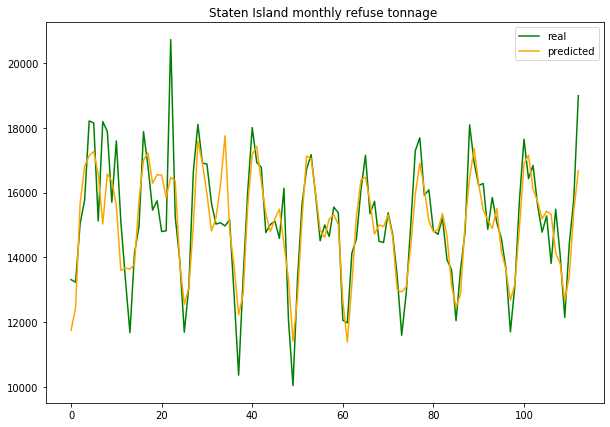

In [19]:
bk_model, results = training_boro_models("Staten Island", plot = True)